In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "/content/drive/My Drive/gala.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!')

Streaming output truncated to the last 5000 lines.
gala/dataset/TrainImages/image1844.jpg         2020-02-15 16:16:04         5356
gala/dataset/TrainImages/image1845.jpg         2020-02-15 16:17:00         2275
gala/dataset/TrainImages/image1849.jpg         2020-02-15 16:19:40         6150
gala/dataset/TrainImages/image1851.jpg         2020-02-15 16:15:58         1448
gala/dataset/TrainImages/image1852.jpg         2020-02-15 16:16:26         4240
gala/dataset/TrainImages/image1854.jpg         2020-02-15 16:15:14         2909
gala/dataset/TrainImages/image1859.jpg         2020-01-02 03:55:42         1599
gala/dataset/TrainImages/image186.jpg          2020-02-15 16:15:50         3347
gala/dataset/TrainImages/image1860.jpg         2020-02-15 16:17:36         2412
gala/dataset/TrainImages/image1861.jpg         2020-01-02 23:28:58         3511
gala/dataset/TrainImages/image1862.jpg         2020-02-15 16:18:44         2646
gala/dataset/TrainImages/image1863.jpg         2020-02-15 16:20:24   

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from skimage import io, transform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

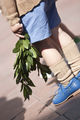

In [0]:
# TEST YOUR VERSION OF PILLOW
# Run this cell. If you see a picture of a cat you're all set!
with Image.open('/content/gala/dataset/TrainImages/image10180.jpg') as im:
    display(im)

In [0]:
dftrain=pd.read_csv('/content/gala/dataset/train.csv')
dftest=pd.read_csv('/content/gala/dataset/test.csv')
target_map={'Food':0, 'misc':1, 'Attire':2, 'Decorationandsignage':3}
# train
dftrain['Class'].unique()
dftrain['Class']=dftrain['Class'].map(target_map)

In [0]:
dftrain[:5000]

,Image,Class
0,image7042.jpg,0
1,image3327.jpg,1
2,image10335.jpg,2
3,image8019.jpg,0
4,image2128.jpg,2
...,...,...
4995,image2020.jpg,2
4996,image4748.jpg,1
4997,image1244.jpg,3
4998,image5905.jpg,1


In [0]:
train=dftrain[:5000]
test=dftrain[5000:]

In [0]:
train['Class'].value_counts()

0    1880
2    1429
1    1066
3     625
Name: Class, dtype: int64

In [0]:
train.head()

,Image,Class
0,image7042.jpg,0
1,image3327.jpg,1
2,image10335.jpg,2
3,image8019.jpg,0
4,image2128.jpg,2


In [0]:
# Start by creating a list
img_sizes = []
rejected = []

for item in train.Image:
    try:
        with Image.open('/content/gala/dataset/TrainImages/'+item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  5000
Rejects: 0


In [0]:
df_img = pd.DataFrame(img_sizes)

# Run summary statistics on image widths
df_img[0].describe(),df_img[1].describe()

(count    5000.0
 mean       80.0
 std         0.0
 min        80.0
 25%        80.0
 50%        80.0
 75%        80.0
 max        80.0
 Name: 0, dtype: float64, count    5000.000000
 mean       74.110000
 std        26.126255
 min        20.000000
 25%        53.000000
 50%        60.000000
 75%        93.000000
 max       235.000000
 Name: 1, dtype: float64)

This tells us the shortest width is 80, the shortest height is 20, the largest width and height are 80 and 235, and that most images have more than 90 pixels per side. This is useful for deciding on an input size. We'll see in the next section that 224x224 will work well for our purposes (we'll take advantage of some pre-trained models that use this size!)

## Image Preprocessing
Any network we define requires consistent input data. That is, the incoming image files need to have the same number of channels (3 for red/green/blue), the same depth per channel (0-255), and the same height and width. This last requirement can be tricky. How do we transform an 800x450 pixel image into one that is 224x224? In the theory lectures we covered the following:
* <a href='https://en.wikipedia.org/wiki/Aspect_ratio_(image)'><strong>aspect ratio</strong></a>: the ratio of width to height (16:9, 1:1, etc.) An 800x450 pixel image has an aspect ration of 16:9. We can change the aspect ratio of an image by cropping it, by stretching/squeezing it, or by some combination of the two. In both cases we lose some information contained in the original. Let's say we crop 175 pixels from the left and right sides of our 800x450 image, resulting in one that's 450x450.
* <strong>scale</strong>: Once we've attained the proper aspect ratio we may need to scale an image up or down to fit our input parameters. There are several libraries we can use to scale a 450x450 image down to 224x224 with minimal loss.
* <a href=''><strong>normalization</strong></a>: when images are converted to tensors, the [0,255] rgb channels are loaded into range [0,1]. We can then normalize them using the generally accepted values of mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. For the curious, these values were obtained by the PyTorch team using a random 10,000 sample of <a href='http://www.image-net.org/'>ImageNet</a> images. There's a good discussion of this <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>here</a>, and the original source code can be found <a href='https://github.com/soumith/imagenet-multiGPU.torch/blob/master/donkey.lua#L154'>here</a>.

## Transformations
Before defining our Convolutional Network, let's look at a sample image and perform various transformations on it to see their effect.

(80, 53)


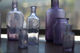

In [0]:
img1=Image.open('/content/gala/dataset/TrainImages/image10029.jpg')
print(img1.size)
display(img1)

This is how jupyter displays the original .jpg image. Note that size is given as (width, height).<br>
Let's look at a single pixel:

In [0]:
r, g, b = img1.getpixel((0, 0))
print(r,g,b)

86 91 95


The pixel at position [0,0] (upper left) of the source image has an rgb value of (90,95,98). This corresponds to <font style="background-color:rgb(90,95,98)">this color </font><br>
Great! Now let's look at some specific transformations.
### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor'><tt>transforms.ToTensor()</tt></a>
Converts a PIL Image or numpy.ndarray (HxWxC) in the range [0, 255] to a <tt>torch.FloatTensor</tt> of shape (CxHxW) in the range [0.0, 1.0]

torch.Size([3, 53, 80])


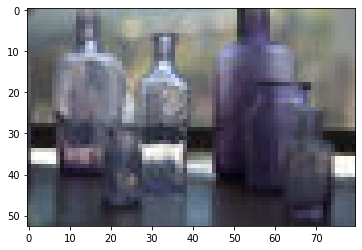

In [0]:
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(img1)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

This is the same image converted to a tensor and displayed using matplotlib. Note that the torch dimensions follow [channel, height, width]<br><br>
PyTorch automatically loads the [0,255] pixel channels to [0,1]:<br><br>
$\frac{242}{255}=0.94\quad\frac{229}{255}=0.89\quad\frac{213}{255}=0.83$


In [0]:
im[:,0,0]

tensor([0.3373, 0.3569, 0.3725])

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize'><tt>transforms.Resize(<em>size</em>)</tt></a>
If size is a sequence like (h, w), the output size will be matched to this. If size is an integer, the smaller edge of the image will be matched to this number.<br>i.e, if height > width, then the image will be rescaled to (size * height / width, size)

torch.Size([3, 224, 338])


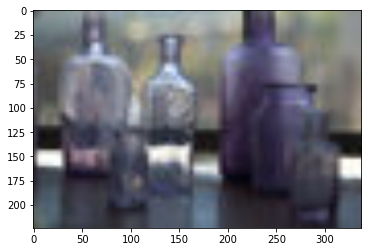

In [0]:
transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])
im = transform(img1)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.CenterCrop'><tt>transforms.CenterCrop(<em>size</em>)</tt></a>
If size is an integer instead of sequence like (h, w), a square crop of (size, size) is made.


## Other affine transformations
An <a href='https://en.wikipedia.org/wiki/Affine_transformation'><em>affine</em></a> transformation is one that preserves points and straight lines. Examples include rotation, reflection, and scaling. For instance, we can double the effective size of our training set simply by flipping the images.
### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip'><tt>transforms.RandomHorizontalFlip(<em>p=0.5</em>)</tt></a>
Horizontally flip the given PIL image randomly with a given probability.

### Scaling is done using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize'><tt>transforms.Resize(<em>size</em>)</tt></a>

torch.Size([3, 224, 224])


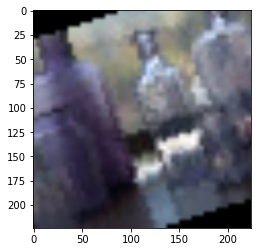

In [0]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.RandomRotation(30),
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(img1)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

___
## Normalization
Once the image has been loaded into a tensor, we can perform normalization on it. This serves to make convergence happen quicker during training. The values are somewhat arbitrary - you can use a mean of 0.5 and a standard deviation of 0.5 to convert a range of [0,1] to [-1,1], for example.<br>However, <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>research has shown</a> that mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] work well in practice.

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt>transforms.Normalize(<em>mean, std</em>)</tt></a>
Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input tensor
### $\quad\textrm {input[channel]} = \frac{\textrm{input[channel] - mean[channel]}}{\textrm {std[channel]}}$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 53, 80])


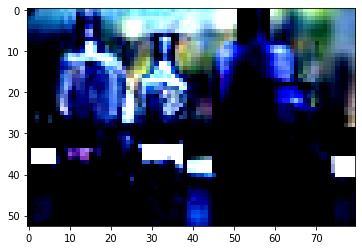

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
im = transform(img1)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Recall that before normalization, the upper-leftmost tensor had pixel values of <tt>[0.3529, 0.3725, 0.3843]</tt>.<br>
With normalization we subtract the channel mean from the input channel, then divide by the channel std.<br><br>
$\frac{(0.3529-0.485)}{0.229}=-0.5767\quad\frac{(0.3725-0.456)}{0.224}=-0.3725\quad\frac{(0.3843-0.406)}{0.225}=-0.0964$<br>

In [0]:
# After normalization:
im[:,0,0]

tensor([-0.6452, -0.4426, -0.1487])

### Optional: De-normalize the images
To see the image back in its true colors, we can apply an inverse-transform to the tensor being displayed.

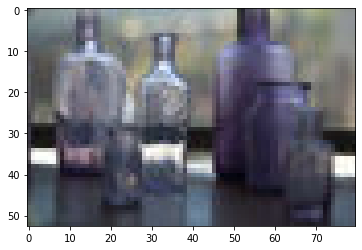

In [0]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


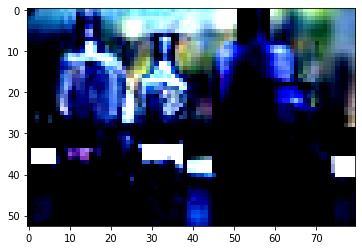

In [0]:
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define transforms
In the previous section we looked at a variety of transforms available for data augmentation (rotate, flip, etc.) and normalization.<br>
Here we'll combine the ones we want, including the <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>recommended normalization parameters</a> for mean and std per channel.

In [0]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

## Prepare train and test sets, loaders

### Custom data set loader

In [0]:
class CustomDataset(Dataset):

    def __init__(self, imgz,labels=None, root_dir='', transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = imgz
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.images[idx])
        image = Image.open(img_name).convert('RGB')
#         plt.imshow(image)
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            return image, self.labels[idx]
        else:
            return image

## Train and Validation

In [0]:
train_data = CustomDataset(imgz=train['Image'].values,labels=train['Class'].values,root_dir='/content/gala/dataset/TrainImages/',transform=train_transform)
test_data = CustomDataset(imgz=test['Image'].values,labels=test['Class'].values,root_dir='/content/gala/dataset/TrainImages/', transform=test_transform)
total_test_data = CustomDataset(imgz=dftest['Image'].values,root_dir='/content/gala/dataset/TestImages/', transform=test_transform)

In [0]:

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)
total_test_loader = DataLoader(total_test_data, batch_size=4, shuffle=False)

class_names = train.Class.unique()

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

[0 1 2 3]
Training images available: 5000
Testing images available:  983


### Total Train and Test

In [0]:
total_train_data = CustomDataset(imgz=dftrain['Image'].values,labels=dftrain['Class'].values,root_dir='/content/gala/dataset/TrainImages/',transform=train_transform)
total_train_loader = DataLoader(total_train_data, batch_size=4, shuffle=True)

## Display a batch of images
To verify that the training loader selects cat and dog images at random, let's show a batch of loaded images.<br>
Recall that imshow clips pixel values <0, so the resulting display lacks contrast. We'll apply a quick inverse transform to the input tensor so that images show their "true" colors.

In [0]:
train_data.__getitem__(2644)

(tensor([[[-0.0629, -0.0629, -0.0801,  ..., -2.1179, -2.1179, -2.1179],
          [ 0.2282,  0.2282,  0.1939,  ..., -2.1179, -2.1179, -2.1179],
          [-0.1999, -0.1999, -0.2171,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ...,  0.5536,  0.4851,  0.4679],
          [-2.1179, -2.1179, -2.1179,  ...,  0.7248,  0.6563,  0.6392],
          [-2.1179, -2.1179, -2.1179,  ...,  0.8104,  0.7419,  0.7248]],
 
         [[ 0.2227,  0.2227,  0.2052,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.5203,  0.5203,  0.4853,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.0826,  0.0826,  0.0651,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ...,  1.0455,  0.9405,  0.9230],
          [-2.0357, -2.0357, -2.0357,  ...,  1.2031,  1.0980,  1.0805],
          [-2.0357, -2.0357, -2.0357,  ...,  1.2556,  1.1506,  1.1331]],
 
         [[ 0.5659,  0.5659,  0.5485,  ..., -1.8044, -1.8044, -1.8044],
          [ 0.8622,  0.8622,

Label: [1 0 0 0]
Class: misc Food Food Food


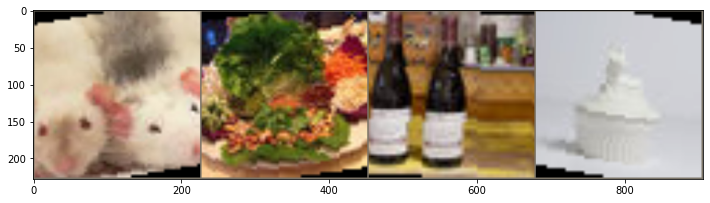

In [0]:
# Grab the first batch of 10 images

target_map_inv={0:'Food', 1:'misc', 2:'Attire', 3:'Decorationandsignage'}
from torchvision.utils import make_grid
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())

print('Class:', *np.array([target_map_inv[i.tolist()] for i in labels]))

im = make_grid(images,nrow=8)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## Define the model
We'll start by using a model similar to the one we applied to the CIFAR-10 dataset, except that here we have a binary classification (2 output channels, not 10). Also, we'll add another set of convolution/pooling layers.

Simple CNN

In [0]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)


<div class="alert alert-info"><strong>Why <tt>(54x54x16)</tt>?</strong><br>
With 224 pixels per side, the kernels and pooling layers result in $\;(((224-2)/2)-2)/2 = 54.5\;$ which rounds down to 54 pixels per side.</div>

### Instantiate the model, define loss and optimization functions
We're going to call our model "CNNmodel" to differentiate it from an "AlexNetmodel" we'll use later.

In [0]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    CNNmodel = CNNmodel.cuda()
    criterion = criterion.cuda()
    
    
# optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
optimizer = torch.optim.SGD(CNNmodel.parameters(), lr=0.001, momentum=0.9)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)

### Looking at the trainable parameters

In [0]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [0]:
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     336
       4
________
 5610392


In [0]:
print(train.shape,test.shape)

(5000, 2) (983, 2)


## Train the model

In [0]:

def test_model(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if torch.cuda.is_available():
                X_test = X_test.cuda()
                y_test = y_test.cuda()
            
            inputs, labels = X_test, y_test
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
 
    print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
def train_model(net, trainloader,epochs):
    for epoch in range(epochs): # no. of epochs
        running_loss = 0
#         exp_lr_scheduler.step()
        for b, (X_train, y_train) in enumerate(train_loader):
            # data pixels and labels to GPU if available
            b+=1
            
            if torch.cuda.is_available():
                X_train = X_train.cuda()
                y_train = y_train.cuda()
            inputs, labels = X_train, y_train
            # set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # propagate the loss backward
            loss.backward()
            # update the gradients
            optimizer.step()
 
            running_loss += loss.item()
        print('[Epoch %d] loss: %.3f' %
                      (epoch + 1, running_loss/len(trainloader)))
        
 
    print('Done Training')
    


## Evaluate model performance

In [0]:
# plt.plot(train_losses, label='training loss')
# plt.plot(test_losses, label='validation loss')
# plt.title('Loss at the end of each epoch')
# plt.legend();

In [0]:
# plt.plot([t for t in train_correct], label='training accuracy')
# plt.plot([t for t in test_correct], label='validation accuracy')
# plt.title('Accuracy at the end of each epoch')
# plt.legend();

In [0]:
# print(test_correct)
# print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

## Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 2.

To access the models, you can construct a model with random weights by calling its constructor:<br>
<pre>resnet18 = models.resnet18()</pre>
You can also obtain a pre-trained model by passing pretrained=True:<br>
<pre>resnet18 = models.resnet18(pretrained=True)</pre>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Feel free to investigate the different models available. Each one will be downloaded to a cache directory the first time they're accessed - from then on they'll be available locally.

For its simplicity and effectiveness, we'll use AlexNet:

In [0]:
from torchvision import datasets, transforms, models # add models to the list
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [0]:
torch.manual_seed(42)
# AlexNetmodel.fc = nn.Sequential(nn.Linear(9216, 1024),
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 4),
                                 nn.LogSoftmax(dim=1))

# for param in AlexNetmodel.fc.parameters():
#     param.requires_grad = True
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [0]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

 9437184
    1024
    4096
       4
________
 9442308


In [0]:
from torch.optim import lr_scheduler


criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    AlexNetmodel = AlexNetmodel.cuda()
    criterion = criterion.cuda()
    
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(AlexNetmodel.classifier.parameters(), lr=0.0001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
torch.cuda.is_available()

False

## Train and Validates model performance

In [0]:
train_model(AlexNetmodel,train_loader,5)
test_model(AlexNetmodel,test_loader)

[Epoch 1] loss: 0.938
[Epoch 2] loss: 0.741
[Epoch 3] loss: 0.651
[Epoch 4] loss: 0.590
[Epoch 5] loss: 0.532
Done Training
Accuracy of the network on test images: 73.957 %


## Predict on Test Set

In [0]:
def prediciton(net, data_loader):
    test_pred = torch.LongTensor()
    for i, data in enumerate(data_loader):
        if torch.cuda.is_available():
            data = data.cuda()
        output = net(data)
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
    
    return test_pred



train_model(AlexNetmodel,total_train_loader,15)

test_pred = prediciton(AlexNetmodel, total_test_loader)

[Epoch 1] loss: 0.398
[Epoch 2] loss: 0.354
[Epoch 3] loss: 0.309
[Epoch 4] loss: 0.268
[Epoch 5] loss: 0.243
[Epoch 6] loss: 0.208
[Epoch 7] loss: 0.198
[Epoch 8] loss: 0.175
[Epoch 9] loss: 0.153
[Epoch 10] loss: 0.142
[Epoch 11] loss: 0.142
[Epoch 12] loss: 0.128


In [0]:
test_pred.numpy().shape

In [0]:
dftest['Class']=test_pred.numpy()
dftest.Class=dftest.Class.map(target_map_inv)

In [0]:
dftest.to_csv('s6_alexnet.csv',index=False)

In [0]:
dftest

(80, 60)


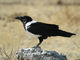

In [0]:
img1=Image.open('/kaggle/input/hackerearth-dl-challengeautotag-images-of-gala/dataset/Test Images/image3442.jpg')
print(img1.size)
display(img1)